In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Introduction to Ensembling/Stacking in Python

In [2]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning
데이터 탐색 및 피쳐 엔지니어링

In [3]:
# train, test 데이터 불러오기
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# PassengerId
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


우리의 임무는 위 데이터의 카테고리 변수에서 정보를 추출하는 것

**Feature Engineering**

In [4]:
full_data = [train, test]

# Name 길이
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Cabin 유무
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) ==  float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# FamilySize = SibSp + Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# IsAlone (FamilySize = 1, IsAlone = 1)
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Embarked 결측치 대체
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Fare 결측치 대체 / CategoricalFare 
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# 승객 이름에서 title 추출하는 함수
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search: # title이 존재하면 추출한 것을 리턴
        return title_search.group(1)
    return ''
# Title
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# 흔하지 않은 title은 'Rare'로 변경
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)
    
    # Mapping Title
    title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    
    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    #Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [5]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

관련 정보를 모두 추출하고 카테고리 변수는 모두 제거하였으므로, 머신 러닝에 적합한 숫자 형식이어야 함

진행 전, 변환된 데이터셋의 상관관계 및 분포도를 관찰

## Visualization

In [6]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


**Pearson Correlation Heatmap**

Seaborn Heatmap을 사용하여 feature간 상관관계 확인

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

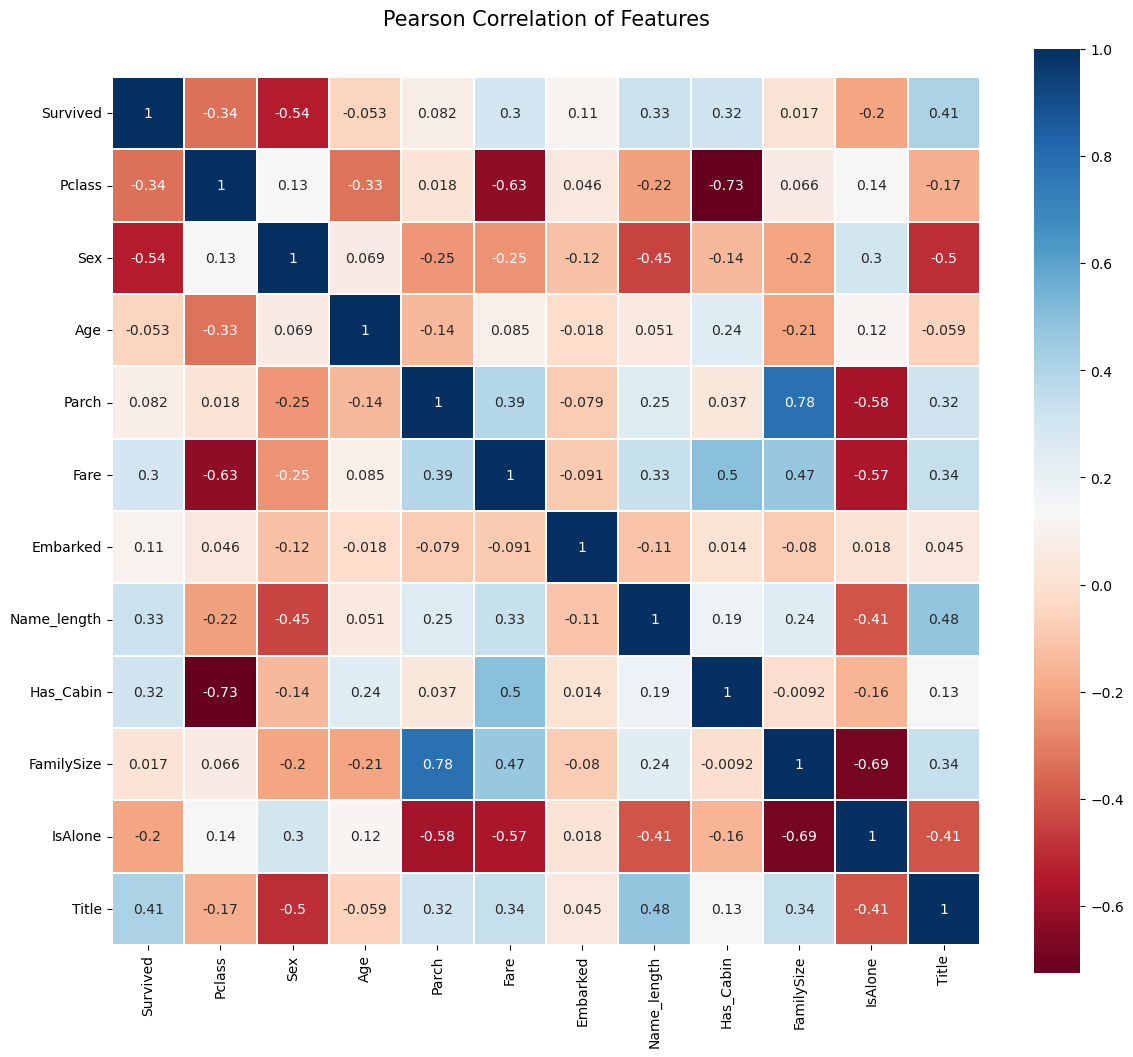

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize = (14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

모든 feature들이 서로 강한 상관관계를 가지지는 않음
- 이는 훈련 데이터에 중복되거나 불필요한 데이터가 많지 않고 각 기능이 고유한 정보를 전달함을 의미
- 가장 관련성이 높은 것은 Parch와 FamilySize

**Pairplots**

하나의 feature에서 다른 feature로의 데이터 분포 관찰

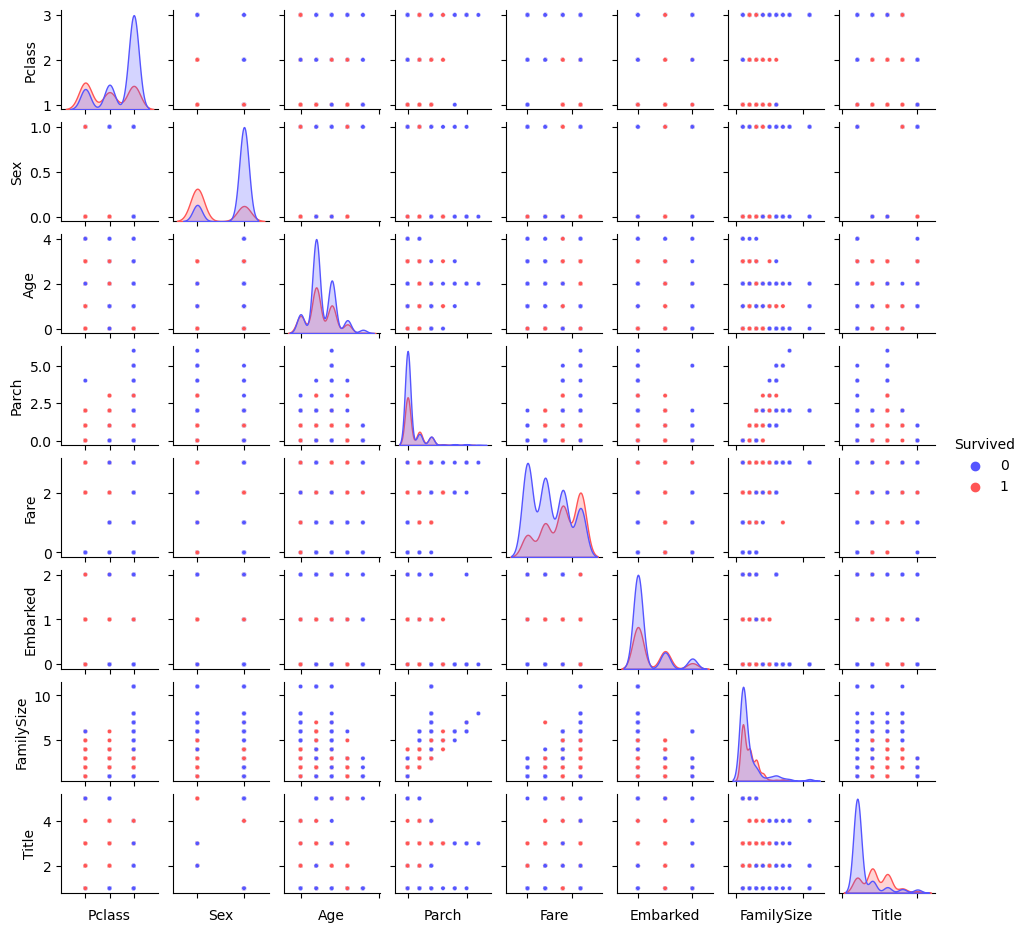

In [8]:
g = sns.pairplot(
    train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch',
           u'Fare', u'Embarked', u'FamilySize', u'Title']],
    hue='Survived', palette='seismic', size=1.2,
    diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

## Ensembling & Stacking models

#### Helpers via Python Classes
파이썬 클래스들은 우리를 더 편리하게 해줌

아래 코드에서 sklearn 분류기의 공통된 내장 메소드(ex. trian, predict, fit)를 확장할 수 있는 SklearnHelper 클래스를 작성
- 5개의 서로 다른 분류기에서 필요할 때마다 같은 메소드를 5번 쓰지 않아도 됨

In [9]:
# parameters
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits = NFOLDS, random_state=SEED, shuffle=True)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)

**def init**: 기본 생성자
- 객체를 생성하기 위해 clf, seed, params 매개변수를 제공해야함
- clf: 원하는 분류기
- seed: 랜덤 시드
- params: 분류기의 파마리터

나머지 코드는 단순히 분류기 내에 존재하는 메소드를 호출하는 함수
- wrapper class를 만들어 다양한 분류기를 구현할 때 같은 코드를 반복해서 작성하는 일을 줄여줌 

#### Out-of_Fold Predictions
기본 분류기들의 예측을 second-level 모델을 훈련하는데 stacking 사용

하지만, 우리는 모든 훈련 데이터로 기본 모델을 훈련시키고, 테스트 데이터로 예측한 다음 second-level 훈련을 위해 결과를 만들어낼 수 없음
- 이렇게 하면 기본 모델이 이미 테스트 데이터를 이미 확인했기 때문에 과적합될 수 있음

In [10]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

## Generating out Base First-Level Models

first-level 분류기를 위해 5개의 학습 모델 준비
1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifier
4. Gradient Boosting classifier
5. Support Vector Machine

**Parameters**
- **n_jobs**: 훈련에 사용할 core 개수(-1로 설정 시 모두 사용)
- **n_estimators**: 학습 모델의 분류 tree 개수(기본값 10)
- **max_depth**: tree의 최대 깊이 또는 node가 얼마나 확장할 지(너무 큰 값을 부여하면 tree가 너무 깊어져 과적합을 불러일으킬 수 있음)
- **verbose**: 학습 중 텍스트 출력 여부(0: X, 3: 모든 반복에서 tree 학습 과정 출력)

In [11]:
# RandomForest
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    # 'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    # 'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost 
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75,
}

# Gradient Boosting
gb_params = {
    'n_estimators': 500,
    # 'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector
svc_params = {
    'kernel' : 'linear',
    'C': 0.025,
}

이전에 생성한 SklearnHelper 함수를 사용하여 5개의 학습 모델을 나타내는 5개의 객체 생성

In [12]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

**train/test 데이터에서 numpy 배열 생성**

첫번째 층의 기본 모델을 준비했으므로 원래 데이터 프레임에서 numpy 배열을 생성하여 분류기에 입력할 훈련/테스트 데이터 준비

In [13]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

**첫번째 층 예측 결과**

훈련/테스트 데이터를 5개의 기본 분류기에 넣고, 이전에 정의한 Out-of-Fole 예측 기능을 사용하여 first-level 예측 결과 생성

In [14]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oot_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print('Training is complete')

Training is complete


**분류기별 feature 중요도**

한 줄의 간단한 코드로 train/test set의 feature 중요도를 출력할 수 있음
- 대부분의 모델은 `.feature_importances` 를 입력하면 확인 가능

In [15]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.10356039 0.20908635 0.03511985 0.02070247 0.04710365 0.02867377
 0.13151887 0.04786177 0.07125224 0.01182926 0.29329139]
[0.11956235 0.38178918 0.02937562 0.01655902 0.05543342 0.02783704
 0.04712421 0.08413698 0.04594405 0.02169928 0.17053884]
[0.032 0.012 0.014 0.066 0.036 0.01  0.686 0.014 0.056 0.004 0.07 ]
[0.08621428 0.01349986 0.05345177 0.01348156 0.05047425 0.0220547
 0.17410973 0.03858991 0.10953466 0.00775528 0.430834  ]


In [16]:
rf_features = [0.10365327, 0.20891648, 0.03294993, 0.01995258, 0.04767557, 0.02930637, 0.13185995, 0.04865679, 0.07180802, 0.01150164, 0.2937194 ]
et_features = [0.1184544, 0.37943581, 0.02849197, 0.01718287, 0.05608059, 0.02907461, 0.04746623, 0.08512565, 0.04371212, 0.02241333, 0.17256243]
ada_features = [0.032, 0.01, 0.022, 0.066, 0.038, 0.01, 0.688, 0.012, 0.048, 0.006, 0.068]
gb_features = [0.08813151, 0.01152051, 0.04855997, 0.01264601, 0.05261525, 0.02633212, 0.17989568, 0.0366745, 0.10793445, 0.00634429, 0.42934571]

plotly 패키지를 사용하여 쉽게 점을 나타낼 수 있도록 feature 중요도가 담긴 리스트로 데이터프레임 생성

In [17]:
cols = train.columns.values

feature_dataframe = pd.DataFrame({
    'features': cols,
    'Random Forest feature importances': rf_features,
    'Extra Trees feature importances': et_features,
    'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
})

**scatterplot을 통한 feature 중요도**

In [18]:
trace = go.Scatter(
    y=feature_dataframe['Random Forest feature importances'].values, 
    x=feature_dataframe['features'].values,
    mode='markers', 
    marker=dict(
        sizemode = 'diameter', 
        sizeref = 1, 
        size = 25, 
        # size = feature_dataframe['AdaBoost feature importances'].values,
        # color = np.random.randn(500),
        color = feature_dataframe['Random Forest feature importances'].values, 
        colorscale='Portland', 
        showscale=True
    ), 
    text = feature_dataframe['features'].values)

data = [trace]
layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    # xaxis = dict(title = 'Pop', ticklen=5, zeroline=False, gridwidth=2),
    yaxis = dict(title='Feature Importance', ticklen=5, gridwidth=2),
    showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Scatter plot
trace = go.Scatter(
    y=feature_dataframe['Extra Trees feature importances'].values, 
    x=feature_dataframe['features'].values,
    mode='markers', 
    marker=dict(
        sizemode = 'diameter', 
        sizeref = 1, 
        size = 25, 
        # size = feature_dataframe['AdaBoost feature importances'].values,
        # color = np.random.randn(500),
        color = feature_dataframe['Extra Trees feature importances'].values, 
        colorscale='Portland', 
        showscale=True
    ), 
    text = feature_dataframe['features'].values)

data = [trace]
layout = go.Layout(
    autosize = True,
    title = 'Extra Trees Feature Importance',
    hovermode = 'closest',
    # xaxis = dict(title = 'Pop', ticklen=5, zeroline=False, gridwidth=2),
    yaxis = dict(title='Feature Importance', ticklen=5, gridwidth=2),
    showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Scatter plot
trace = go.Scatter(
    y=feature_dataframe['AdaBoost feature importances'].values, 
    x=feature_dataframe['features'].values,
    mode='markers', 
    marker=dict(
        sizemode = 'diameter', 
        sizeref = 1, 
        size = 25, 
        # size = feature_dataframe['AdaBoost feature importances'].values,
        # color = np.random.randn(500),
        color = feature_dataframe['AdaBoost feature importances'].values, 
        colorscale='Portland', 
        showscale=True
    ), 
    text = feature_dataframe['features'].values)

data = [trace]
layout = go.Layout(
    autosize = True,
    title = 'AdaBoost Feature Importance',
    hovermode = 'closest',
    # xaxis = dict(title = 'Pop', ticklen=5, zeroline=False, gridwidth=2),
    yaxis = dict(title='Feature Importance', ticklen=5, gridwidth=2),
    showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Scatter plot
trace = go.Scatter(
    y=feature_dataframe['Gradient Boost feature importances'].values, 
    x=feature_dataframe['features'].values,
    mode='markers', 
    marker=dict(
        sizemode = 'diameter', 
        sizeref = 1, 
        size = 25, 
        # size = feature_dataframe['AdaBoost feature importances'].values,
        # color = np.random.randn(500),
        color = feature_dataframe['Gradient Boost feature importances'].values, 
        colorscale='Portland', 
        showscale=True
    ), 
    text = feature_dataframe['features'].values)

data = [trace]
layout = go.Layout(
    autosize = True,
    title = 'Gradient Boost Feature Importance',
    hovermode = 'closest',
    # xaxis = dict(title = 'Pop', ticklen=5, zeroline=False, gridwidth=2),
    yaxis = dict(title='Feature Importance', ticklen=5, gridwidth=2),
    showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

feature 중요도의 평균을 구해 새로운 데이터 프레임으로 저장

In [19]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head()

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.103653,0.118454,0.032,0.088132,0.085560
1,Sex,0.208916,0.379436,0.010,0.011521,0.152468
2,Age,0.032950,0.028492,0.022,0.048560,0.033000
3,Parch,0.019953,0.017183,0.066,0.012646,0.028945
4,Fare,0.047676,0.056081,0.038,0.052615,0.048593


**Barplot으로 feature 중요도 나타내기**

평균값을 barplot으로 나타냄

In [20]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x = x,
            y = y,
            width = 0.5,
            marker = dict(
                color = feature_dataframe['mean'].values,
                colorscale = 'Portland',
                showscale = True,
                reversescale = False
                ), 
                opacity = 0.6
        )]

layout = go.Layout(
    autosize = True,
    title = 'Barplots of Mean Feature Importance',
    hovermode = 'closest',
    # xaxis = dict(title='Pop', ticklen=5, zeroline=False,  gridwidth=2),
    yaxis = dict(title='Feature Importance', ticklen=5, gridwidth=2),
    showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')